In [1]:
import autograd.numpy as np
from numpy.polynomial import Polynomial
import matplotlib.pyplot as plt

In [2]:
def rk4(f, trange, h, x0, u):
    if type(u) in [int, float]:
        u = np.array([[u]])
    rk_coef = np.array([1, 2, 2, 1], dtype=float)
    t = np.arange(trange[0], trange[1], h)
    xt = np.empty((len(t), len(x0), 1), dtype=float)
    xt[0,:,:]=x0
    k=np.empty((len(x0),4,1), dtype=float)
    for step, current_t in enumerate(t[:-1]):
        k[:,0,:] = f(current_t, xt[step], u)
        k[:,1,:] = f(current_t + (h/2), xt[step] + ((h/2)*k[:,0,:]), u)
        k[:,2,:] = f(current_t + (h/2), xt[step] + ((h/2)*k[:,1,:]), u)
        k[:,3,:] = f(current_t, xt[step] + (h*k[:,2,:]), u)
        final_diff = (rk_coef*np.squeeze(k)).sum(axis=1).reshape(-1,1)
        xt[step+1] = xt[step] + ((h/6)*final_diff)
    return t, xt

In [3]:
def plot(t, xt):
    fig, ax = plt.subplots(1,1, figsize=(16,9))
    ax.grid()
    for i in range(xt.shape[1]):
        ax.plot(t, xt[:,i], label=rf'$x_{i}$')
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('Signal')
    ax.legend()
    return fig, ax

In [4]:
def get_poly_str(poly:Polynomial, var='s'):
    coefs = poly.coef
    deg = poly.degree()
    poly_text = ''
    for coef, exponent in zip(coefs[::-1], range(deg, -1, -1)):
        if coef == 0:
            continue

        if poly_text:
            poly_text += '+'
        
        if coef.is_integer():
            coef = int(coef)
        
        if exponent == 0:
            poly_text += f'{coef}'
        elif coef == 1:
            poly_text +=f'{var}'
        else:
            poly_text += f'{coef}{var}'
        
        if exponent > 1:
            poly_text += f'^{{{exponent}}}'
    return poly_text

In [5]:
def rlocus(num, den, style='numpy', krange=None):
    if style == 'numpy':
        num = Polynomial(num)
        den = Polynomial(den)
    elif style == 'matlab':
        num = Polynomial(num[::-1])
        den = Polynomial(den[::-1])
    else:
        raise NotImplementedError

    if krange is None:
        krange = (0,1000,1)
    
    ff_poles = den.roots()
    ff_zeros = num.roots()
    kps = np.arange(*krange)
    fb_poles = np.empty((len(kps), den.degree()), dtype=np.complex64)
    for i, kp in enumerate(kps):
        char_poly = den + (kp*num)
        fb_poles[i] = char_poly.roots()
    
    fig, ax = plt.subplots(1,1)
    for ipole in range(fb_poles.shape[1]):
        real_x = np.real(fb_poles[:, ipole])
        imag_y = np.imag(fb_poles[:, ipole])
        line = ax.plot(real_x, imag_y)
        pole=fb_poles[0, ipole]
        sign = '+' if np.sign(pole.imag) else '-'
        label='Pole {:0.2f}{sign}{:0.2f}j'.format(pole.real, np.abs(pole.imag), sign=sign)
        ax.scatter(real_x[0], imag_y[0], marker='x', label=label)
    for zero in ff_zeros:
        sign = '+' if np.sign(zero.imag) else '-'
        label = 'Zero {:0.2f}{sign}{:0.2f}j'.format(zero.real, np.abs(zero.imag), sign=sign)
        ax.scatter(np.real(zero), np.imag(zero), marker='o', label=label)
    ax.legend()
    ax.grid()
    title = f'Root Locus'
    # num_text = get_poly_str(num)
    # den_text = get_poly_str(den)
    # props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    # tf_text = f'$G_{{ff}} = \\frac{{{num_text}}}{{{den_text}}}$'
    # fig.text(0.15, 0.85, tf_text,va='top', wrap=True, bbox=props, fontsize='large')
    ax.set_title(title, fontsize='xx-large')
    ax.set(xlabel='Real', ylabel='Im', title = title)
    return kps, fb_poles, fig, ax

In [6]:
kp = 6.25
ki=kp
c0=5
c1=6
A = np.array([
    [0,-1,0],
    [0, 0, 1],
    [ki, (-c0-kp), -c1]
])
B = np.array([
    [1],
    [0],
    [kp]
])
C = np.array([[0,1,0]])
D = np.array([[0]])

def dynamical_sys(t,x,u):
    dx = A@x + B@u
    return dx

A, B, C, D

(array([[  0.  ,  -1.  ,   0.  ],
        [  0.  ,   0.  ,   1.  ],
        [  6.25, -11.25,  -6.  ]]),
 array([[1.  ],
        [0.  ],
        [6.25]]),
 array([[0, 1, 0]]),
 array([[0]]))

## Escolhendo os ganhos do controlador pelo Root Locus

Text(0.5, 1.0, 'Root Locus do sistema usual')

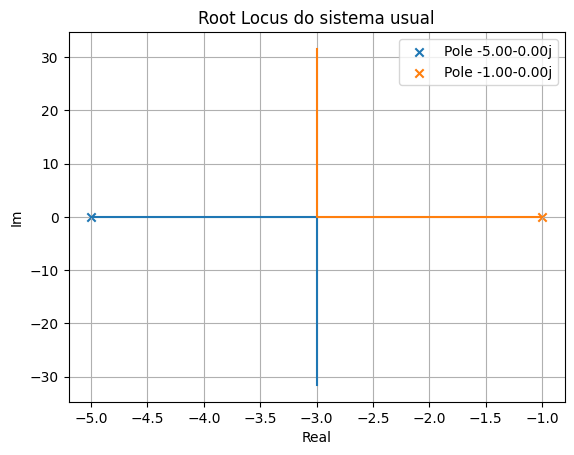

In [14]:
kps, fb_poles, fig, ax = rlocus([1],[1,c1,c0], style='matlab')
ax.set_title('Root Locus do sistema usual')

Text(0.5, 1.0, 'Root Locus malha aberta do sistema com controlador para escolha do zero')

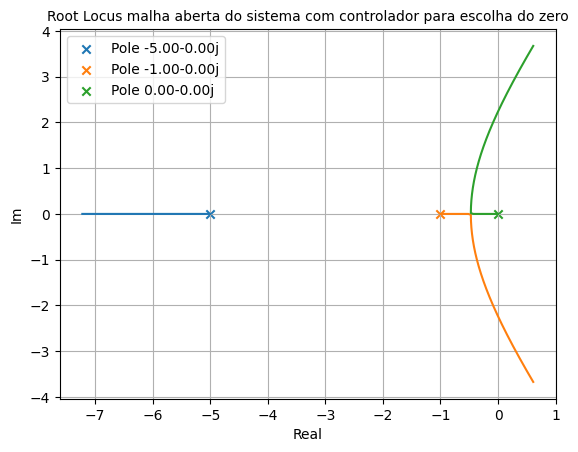

In [15]:
kps, fb_poles, fig, ax = rlocus([1],[1,c1,c0, 0], style='matlab', krange=(0,100,0.01))
ax.set_title('Root Locus malha aberta do sistema com controlador para escolha do zero', fontsize='medium')

O controle PI permite a alocação de um zero real negativo no root locus acima.

O lugar das raízes de um pólo sempre possui um grau relativo impar a sua direita. Isso significa que o número de pólos menos o número de zeros a direita do gráfico desse ímpar. Dessa forma, se um zero for posto entre -5 e -1, o gráfico azul irá para a direita, em direção a esse zero sem mudar a velocidade do sistema. 

Se colocarmos um zero a esquerda de -5, o gráfico azul estará limitado a esquerda pelo novo zero, o que é indesejado, pois quanto mais a esquerda for possível alocar um pólo melhor.

Se colocarmos um zero no intervalo [-1, 0), o pólo 0 (verde) irá em direção desse novo zero e os pólos -1 e -5 (laranja e azul) irão se chocar em um ponto entre eles e divergir para o infinito numa direção de 90 graus em sentidos opostos. Como quanto mais negativo mais rápido o sistema, logo, escolhe-se zomo alocação de zero o valor -1.

O zero -1, em especial, cancela o pólo natural mais lento do sistema, gerando o último gráfico de root locus abaixo. Ao definir como meta de projeto o sistema resultante mais rápido possível que não oscile, o ganho proporcional é escolhido de forma a gerar o pólo em -2.5, o ponto no qual os lugares das raízes se encontrma antes de irem ao infinito. O ganho integral do controle é encontrado naturalmente como o ganho que mantém os pólos resultantes e o zero desejados.

Text(0.5, 1.0, 'Root Locus malha aberta sistema com zero em -2')

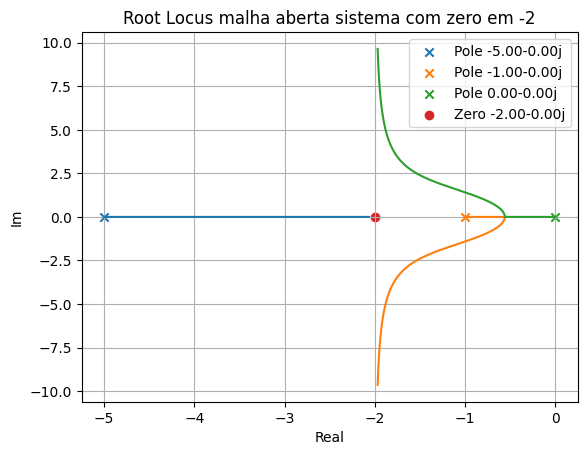

In [18]:
kps, fb_poles, fig, ax = rlocus([1, 2],[1,c1,c0, 0], style='matlab', krange=(0,100,0.01))
ax.set_title('Root Locus malha aberta sistema com zero em -2')

Text(0.5, 1.0, 'Root Locus malha aberta sistema com zero em -7')

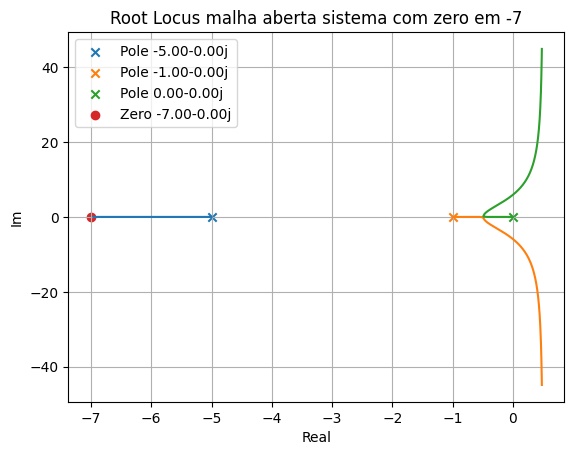

In [25]:
kps, fb_poles, fig, ax = rlocus([1, 7],[1,c1,c0, 0], style='matlab', krange=(0,2000,0.01))
ax.set_title('Root Locus malha aberta sistema com zero em -7')

Text(0.5, 1.0, 'Root Locus malha aberta sistema com zero em -0.7')

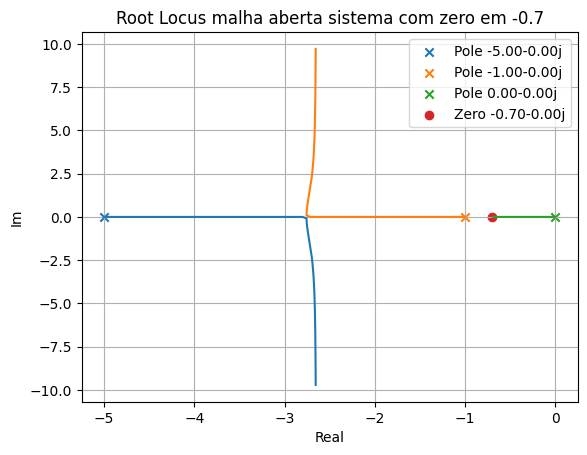

In [23]:
kps, fb_poles, fig, ax = rlocus([1, 0.7],[1,c1,c0, 0], style='matlab', krange=(0,100,0.01))
ax.set_title('Root Locus malha aberta sistema com zero em -0.7')

Text(0.5, 1.0, 'Root Locus malha aberta sistema com zero em -1')

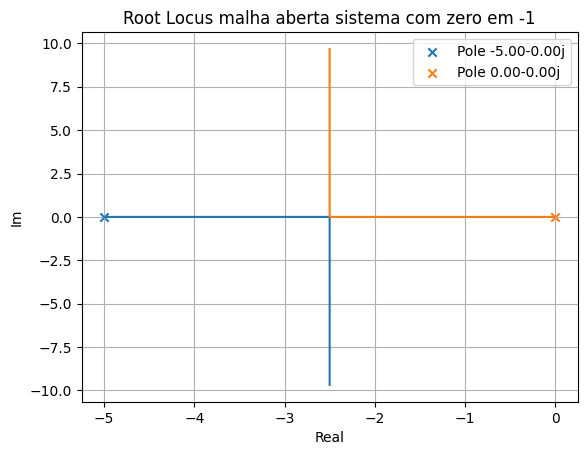

In [19]:
kps, fb_poles, fig, ax = rlocus([1],[1,5,0], style='matlab', krange=(0,100,0.01))
ax.set_title('Root Locus malha aberta sistema com zero em -1')

Text(0.5, 1.0, 'Resposta do sistema em malha fechada com zero em -1')

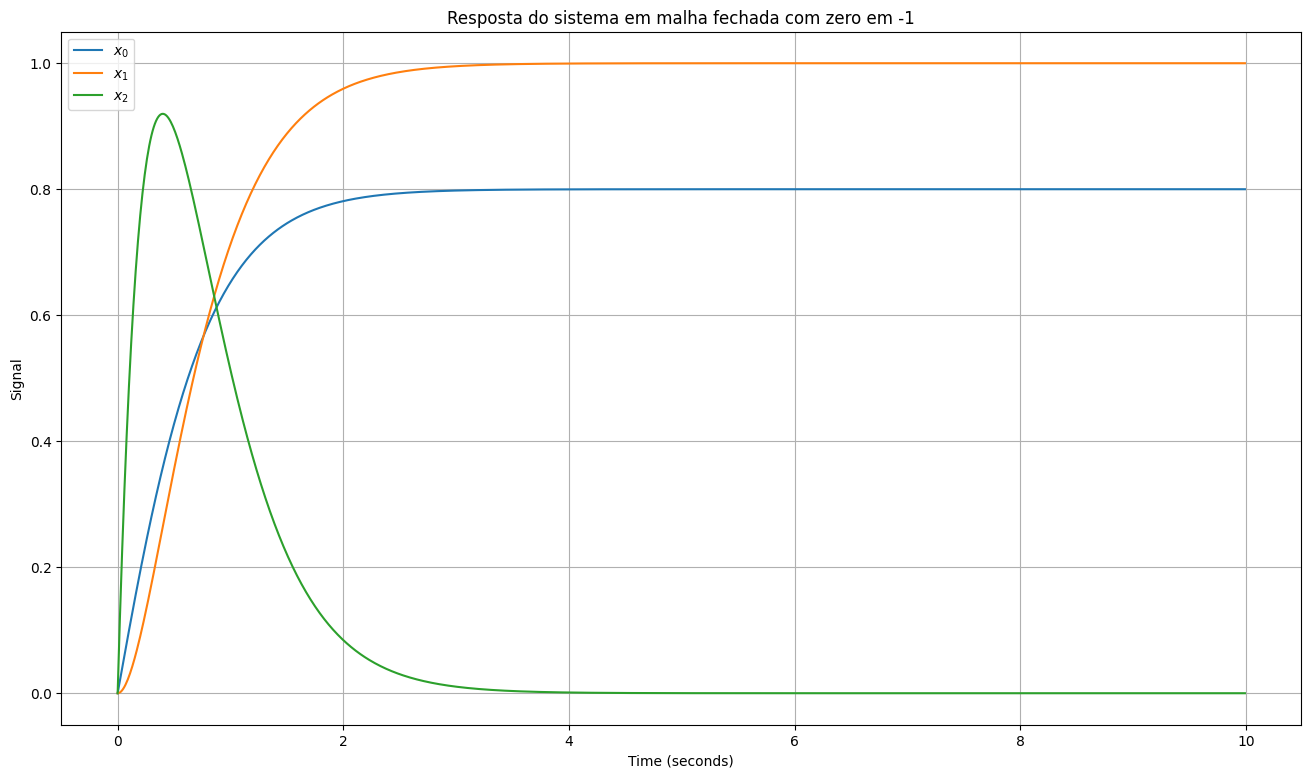

In [26]:
h=0.01
trange=[0,10]
x0=np.array([0,0,0]).reshape(-1,1)
ref=1
t, xt = rk4(dynamical_sys, trange, h, x0, ref)
fig, ax = plot(t, xt)
ax.set_title('Resposta do sistema em malha fechada com zero em -1')